In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.timeseries import LombScargle
from scipy.signal import savgol_filter
from astropy.convolution import convolve, Box1DKernel
from scipy.stats import binned_statistic
import scipy.stats as st
import astropy.units as u
import pandas as pd
import matplotlib
params={
    'text.usetex':True,
    'font.family':'serif',
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True
}
matplotlib.rcParams.update(params)

In [5]:
# base = 'AS1G05_230T02_9000000548uvtFIIPC00F1_l2ce'
# directory = ['/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_01/F_01/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_02/F_02/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_03/F_03/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_04/F_04/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_05/F_05/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_06/F_06/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_07/F_07/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_08/F_08/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_09/F_09/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_11/F_11/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_13/F_13/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_15/F_15/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_17/F_17/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_19/F_19/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_20/F_20/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_21/F_21/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_22/F_22/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_23/F_23/']

# MJD = []
# counts = []
# counts_err = []
# source = pd.DataFrame(pd.read_csv('sources_new.csv'))
# for i in range(len(directory)):
#     data = pd.read_csv(directory[i]+'makecurves_'+str(source['xp'][i])+'_'+str(source['yp'][i])+'_'+base+'.dat', delimiter='	')
#     lc = pd.DataFrame(data)
#     MJD.append(lc.iloc[:, 0].values)
#     counts.append(lc.iloc[:, 1].values)
#     counts_err.append(lc.iloc[:, 2].values)
# MJD = np.concatenate(MJD)
# counts = np.concatenate(counts)
# counts_err = np.concatenate(counts_err)
# #np.savetxt('lc.txt', np.c_[MJD, counts, counts_err], delimiter=',', header='MJD, counts, counts_err')
# #MJD = 2444884.2176 + MJD*0.07891518

In [44]:
df = pd.DataFrame(pd.read_csv('lc.txt', delimiter=','))
MJD = df['MJD'].values
counts = df[' counts'].values
counts_err = df[' counts_err'].values

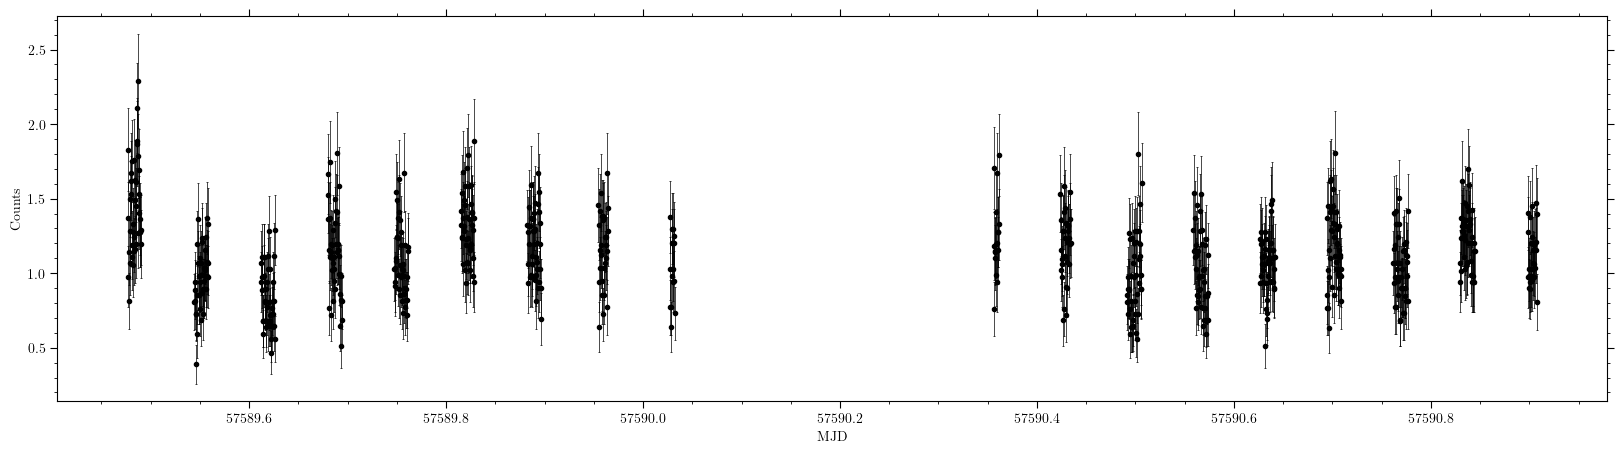

In [45]:
plt.figure(figsize=(20, 5))
plt.errorbar(MJD, counts, yerr=counts_err, fmt='o', color='k', ms=3, elinewidth=0.5, capsize=1, capthick=0.5)
plt.xlabel('MJD')
plt.ylabel('Counts')
plt.show()

$\text{HJD}  = 2444884.2176(6) + 0.07891518(4)\times \text{E}$

160798
[17.85655036 17.85689758 17.8572448  17.85759203 17.85793925 17.85828647
 17.85863369 17.85898091 17.85932814 17.85967536 17.86002258 17.8603698
 17.86071703 17.86106425 17.86141147 17.86175869 17.86210591 17.86245314
 17.86280036 17.86314758 17.8634948  17.86384203 17.86418925 17.86453647
 17.86488369 17.86523091 17.86557814 17.86592536 17.78774438 17.78809161
 17.78843883 17.78878605 17.78913327 17.78948049 17.78982772 17.79017494
 17.79052216 17.79086938 17.79121661 17.79156383 17.79191105 17.79225827
 17.7926055  17.79295272 17.79329994 17.79364716 17.79399438 17.79434161
 17.79468883 17.79503605 17.79538327 17.79573049 17.79607772 17.79642494
 17.79677216 17.79711938 17.79746661 17.79781383 17.79816105 17.79850827
 17.79885549 17.79920272 17.79954994 17.79989716 17.80024438 17.80059161
 17.80093883 17.80128605 17.80163327 17.80198049 17.80232772 17.80267494
 17.72010583 17.72045305 17.72080027 17.7211475  17.72149472 17.72184194
 17.72218916 17.72253639 17.72288361 17.72323

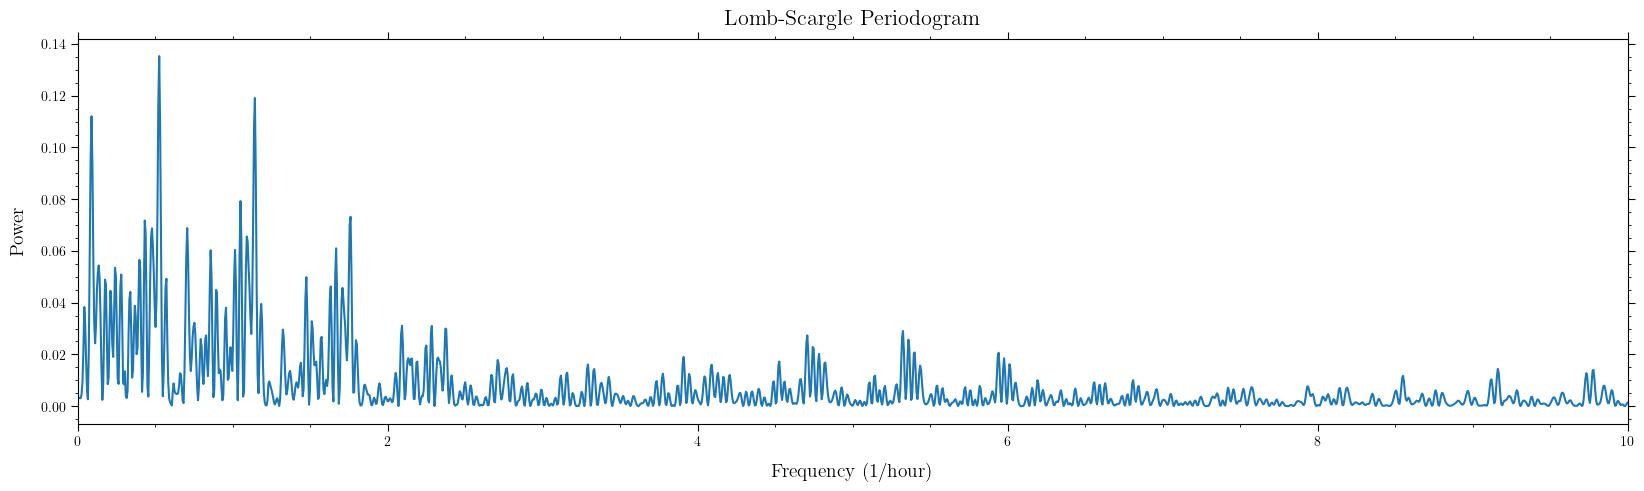

In [46]:
#correct for ephimeris
i = 0
JD = MJD + 2400000.5
while True:
    if (2444901.9744+0.07891507*i)/JD[0] >=1:
        print(i-1)
        break
    i += 1
MJD = JD - (2444884.2176+0.07891518*160797)
MJD_days = MJD*u.day
#convert to hours
MJD_hour = MJD*24
frequency, power = LombScargle(MJD_hour, counts).autopower()
plt.figure(figsize=(20, 5))
plt.plot(frequency, power)
plt.xlabel('Frequency (1/hour)', fontsize=14, labelpad=10)
plt.ylabel('Power', fontsize=14, labelpad=10)
plt.title('Lomb-Scargle Periodogram', fontsize=16, pad=10)
plt.xlim(0,10)
plt.show()

In [47]:
best_frequency = frequency[np.argmax(power)]
t_fit = np.linspace(0, 1)
ls = LombScargle(MJD_hour, counts, counts_err)
y_fit = ls.model(t_fit, best_frequency)
best_period = 1/best_frequency
print('Best period:', best_period, "hours")

Best period: 1.8974131096710156 hours


Text(0.5, 1.0, 'Phase-folded light curve')

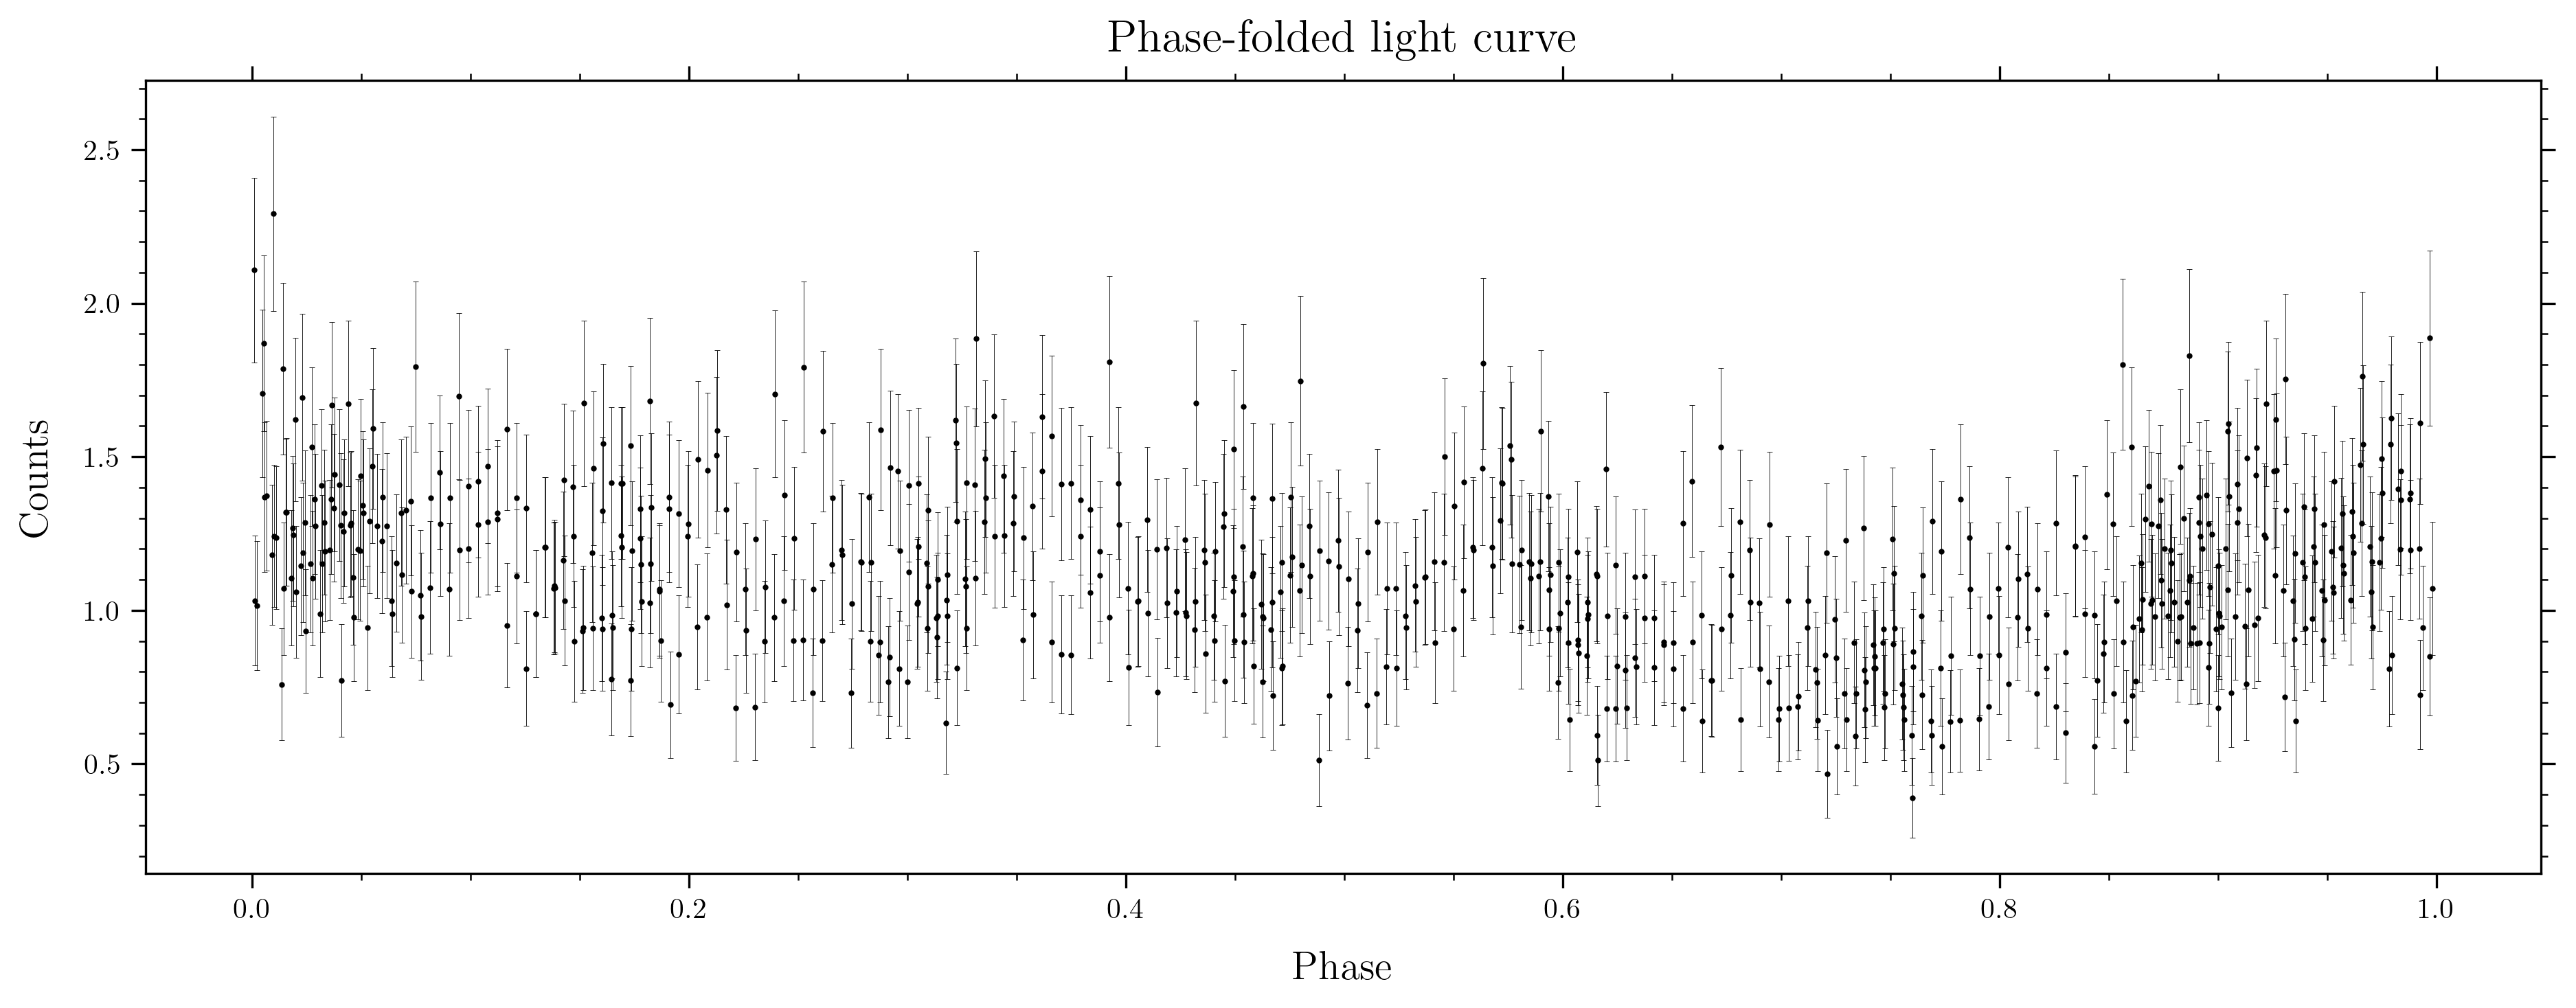

In [48]:
phase = (MJD_hour)/best_period-np.floor((MJD_hour)/best_period)
sort = np.argsort(phase)
plt.figure(figsize=(15, 5), dpi=300)
plt.errorbar(phase[sort], counts[sort], counts_err[sort],fmt='o', color='black', ms=1, elinewidth=0.2, capsize=1, capthick=0.2)
plt.xlabel('Phase', fontsize=14, labelpad=10)
plt.ylabel('Counts', fontsize=14, labelpad=10)
plt.title('Phase-folded light curve', fontsize=16, pad=10)

674


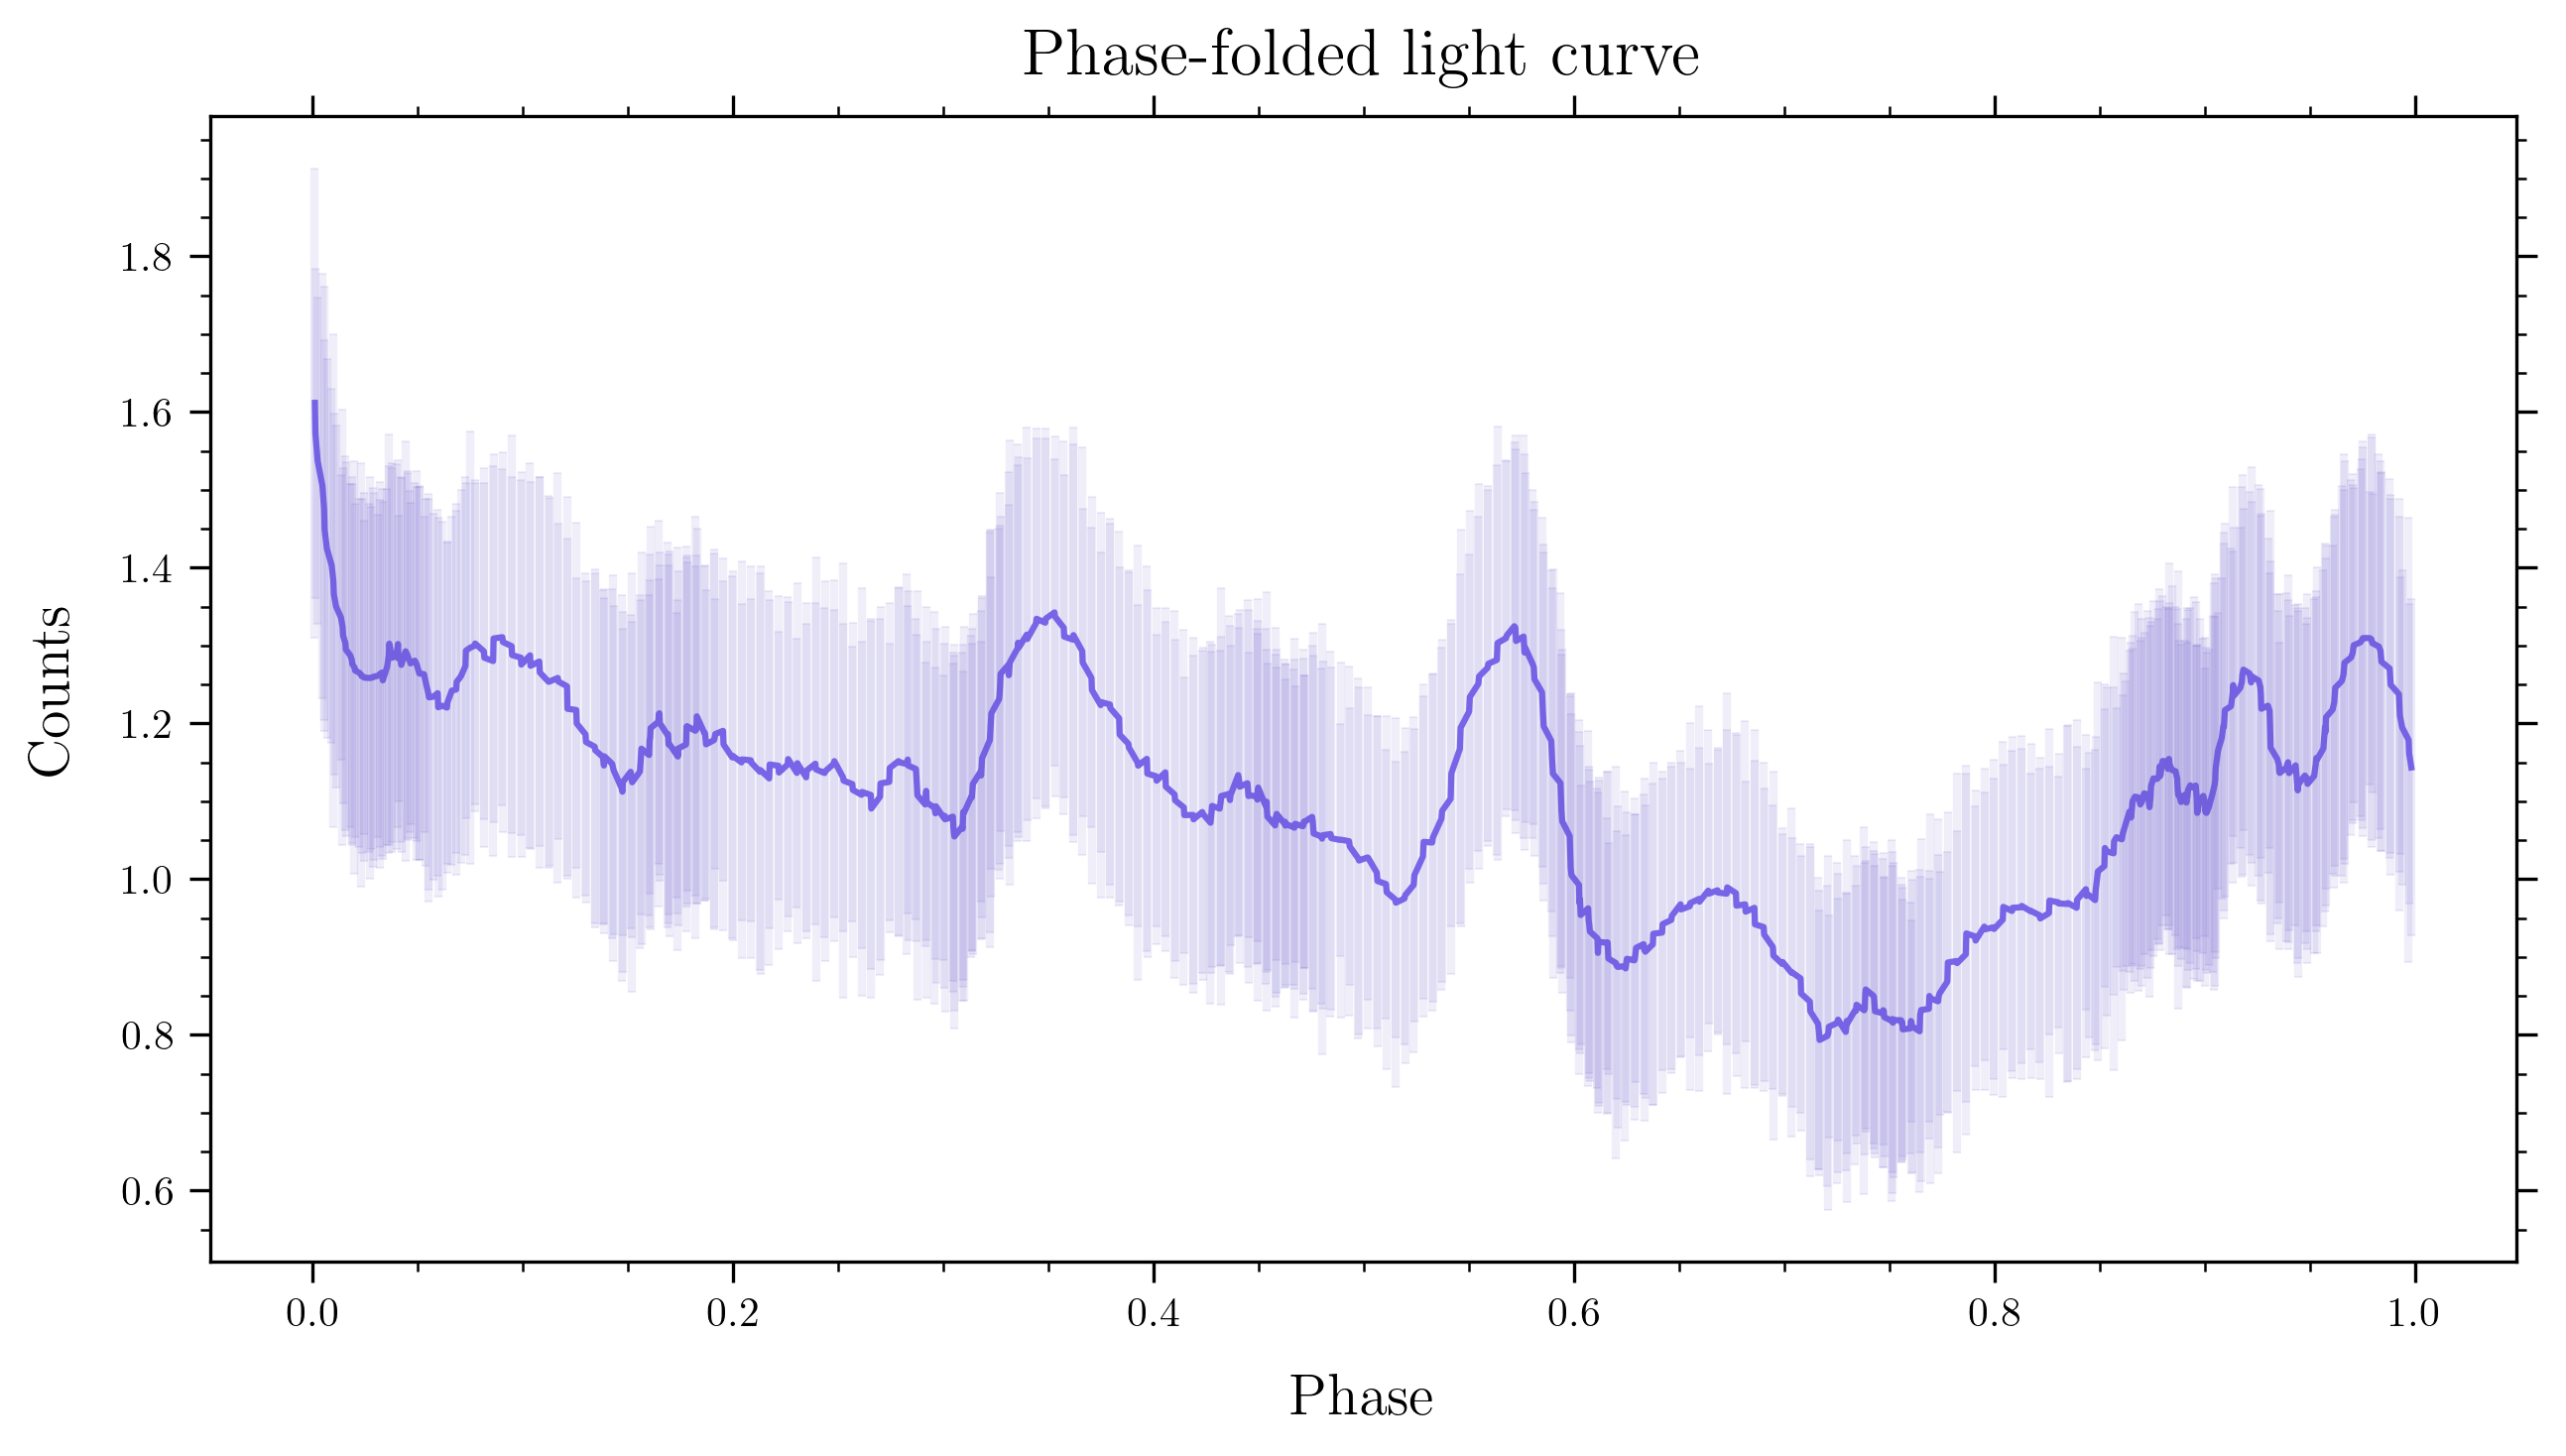

In [49]:
sorted_phase = phase[sort]
sorted_counts = counts[sort]
sorted_counts_err = counts_err[sort]
print(len(sorted_counts))
filtered_counts = savgol_filter(sorted_counts, 69, 5)
filtered_error = savgol_filter(sorted_counts_err, 50, 5)
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(sorted_phase, filtered_counts, color='mediumslateblue')
plt.errorbar(sorted_phase, filtered_counts, sorted_counts_err, fmt='o', color='slateblue', ms=0, elinewidth=2, alpha=0.1, capsize=1, capthick=0.5)
plt.xlabel('Phase', fontsize=14, labelpad=10)
plt.ylabel('Counts', fontsize=14, labelpad=10)
plt.title('Phase-folded light curve', fontsize=16, pad=10)
plt.show()

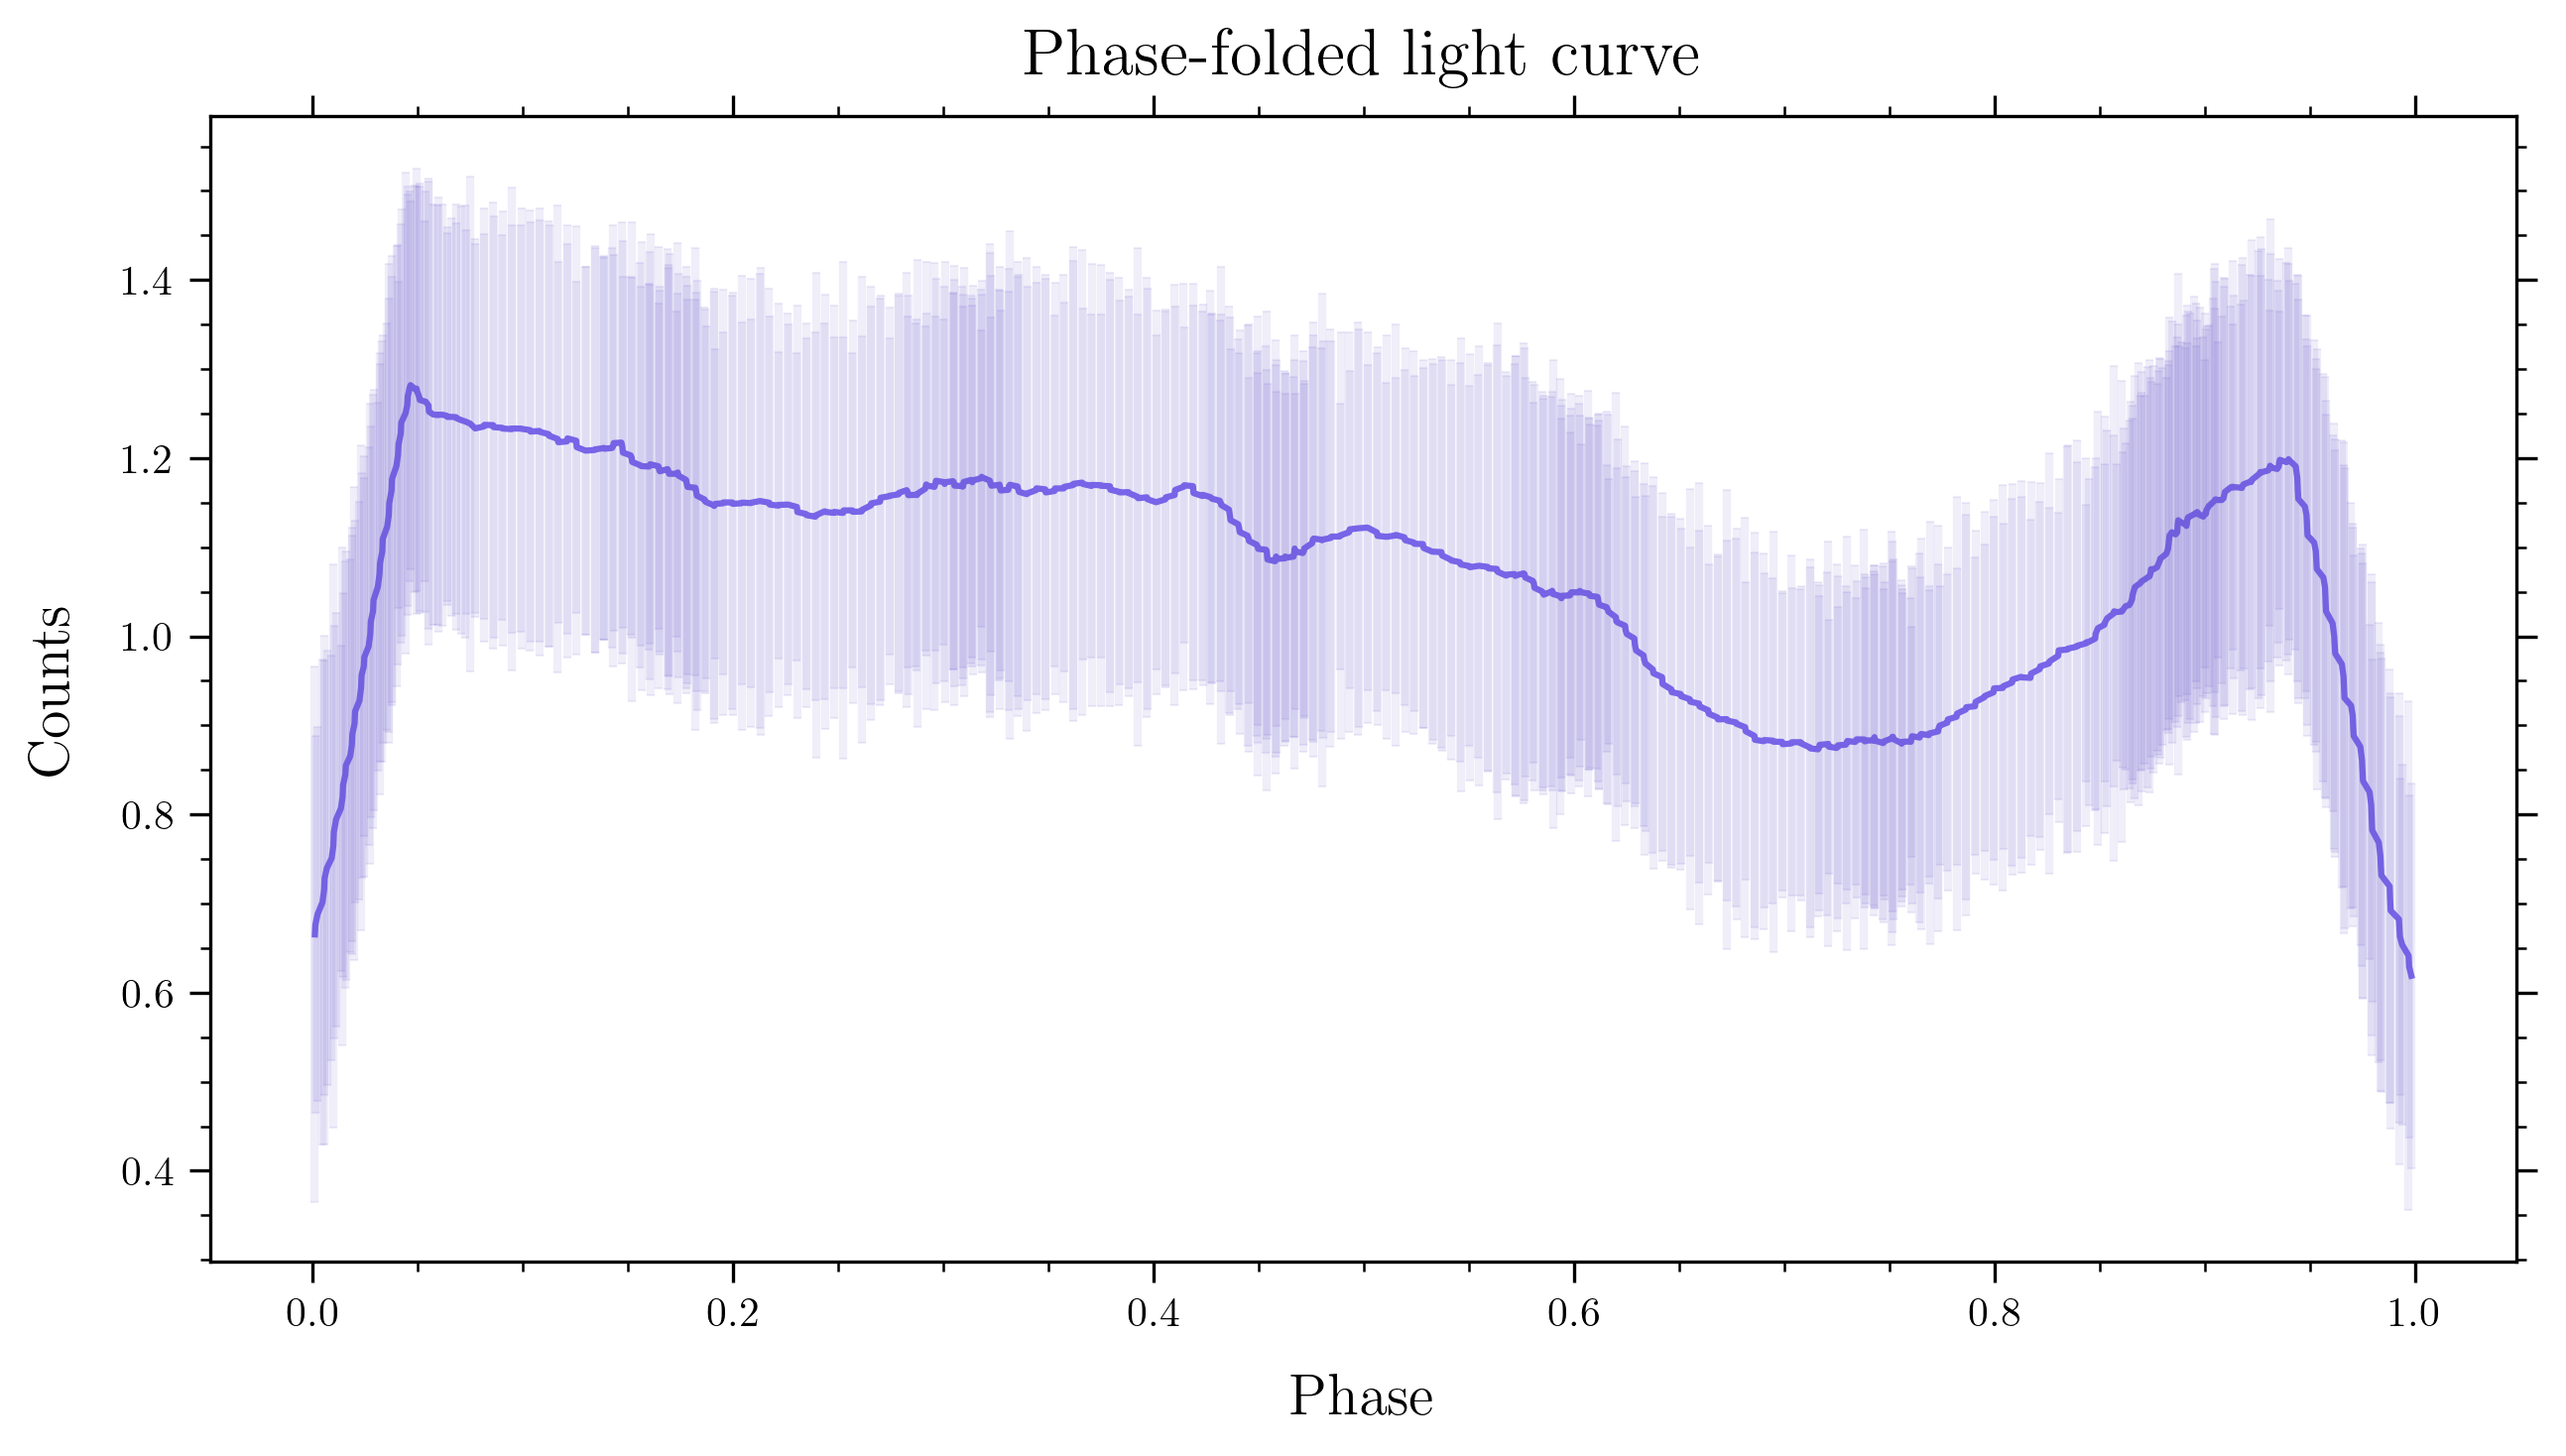

In [50]:
#astropy convolution
box_kernel = Box1DKernel(100)
smoothed_counts = convolve(sorted_counts, box_kernel)
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(sorted_phase, smoothed_counts, color='mediumslateblue')
plt.errorbar(sorted_phase, smoothed_counts, sorted_counts_err, fmt='o', color='slateblue', ms=0, elinewidth=2, alpha=0.1, capsize=1, capthick=0.5)
plt.xlabel('Phase', fontsize=14, labelpad=10)
plt.ylabel('Counts', fontsize=14, labelpad=10)
plt.title('Phase-folded light curve', fontsize=16, pad=10)
plt.show()

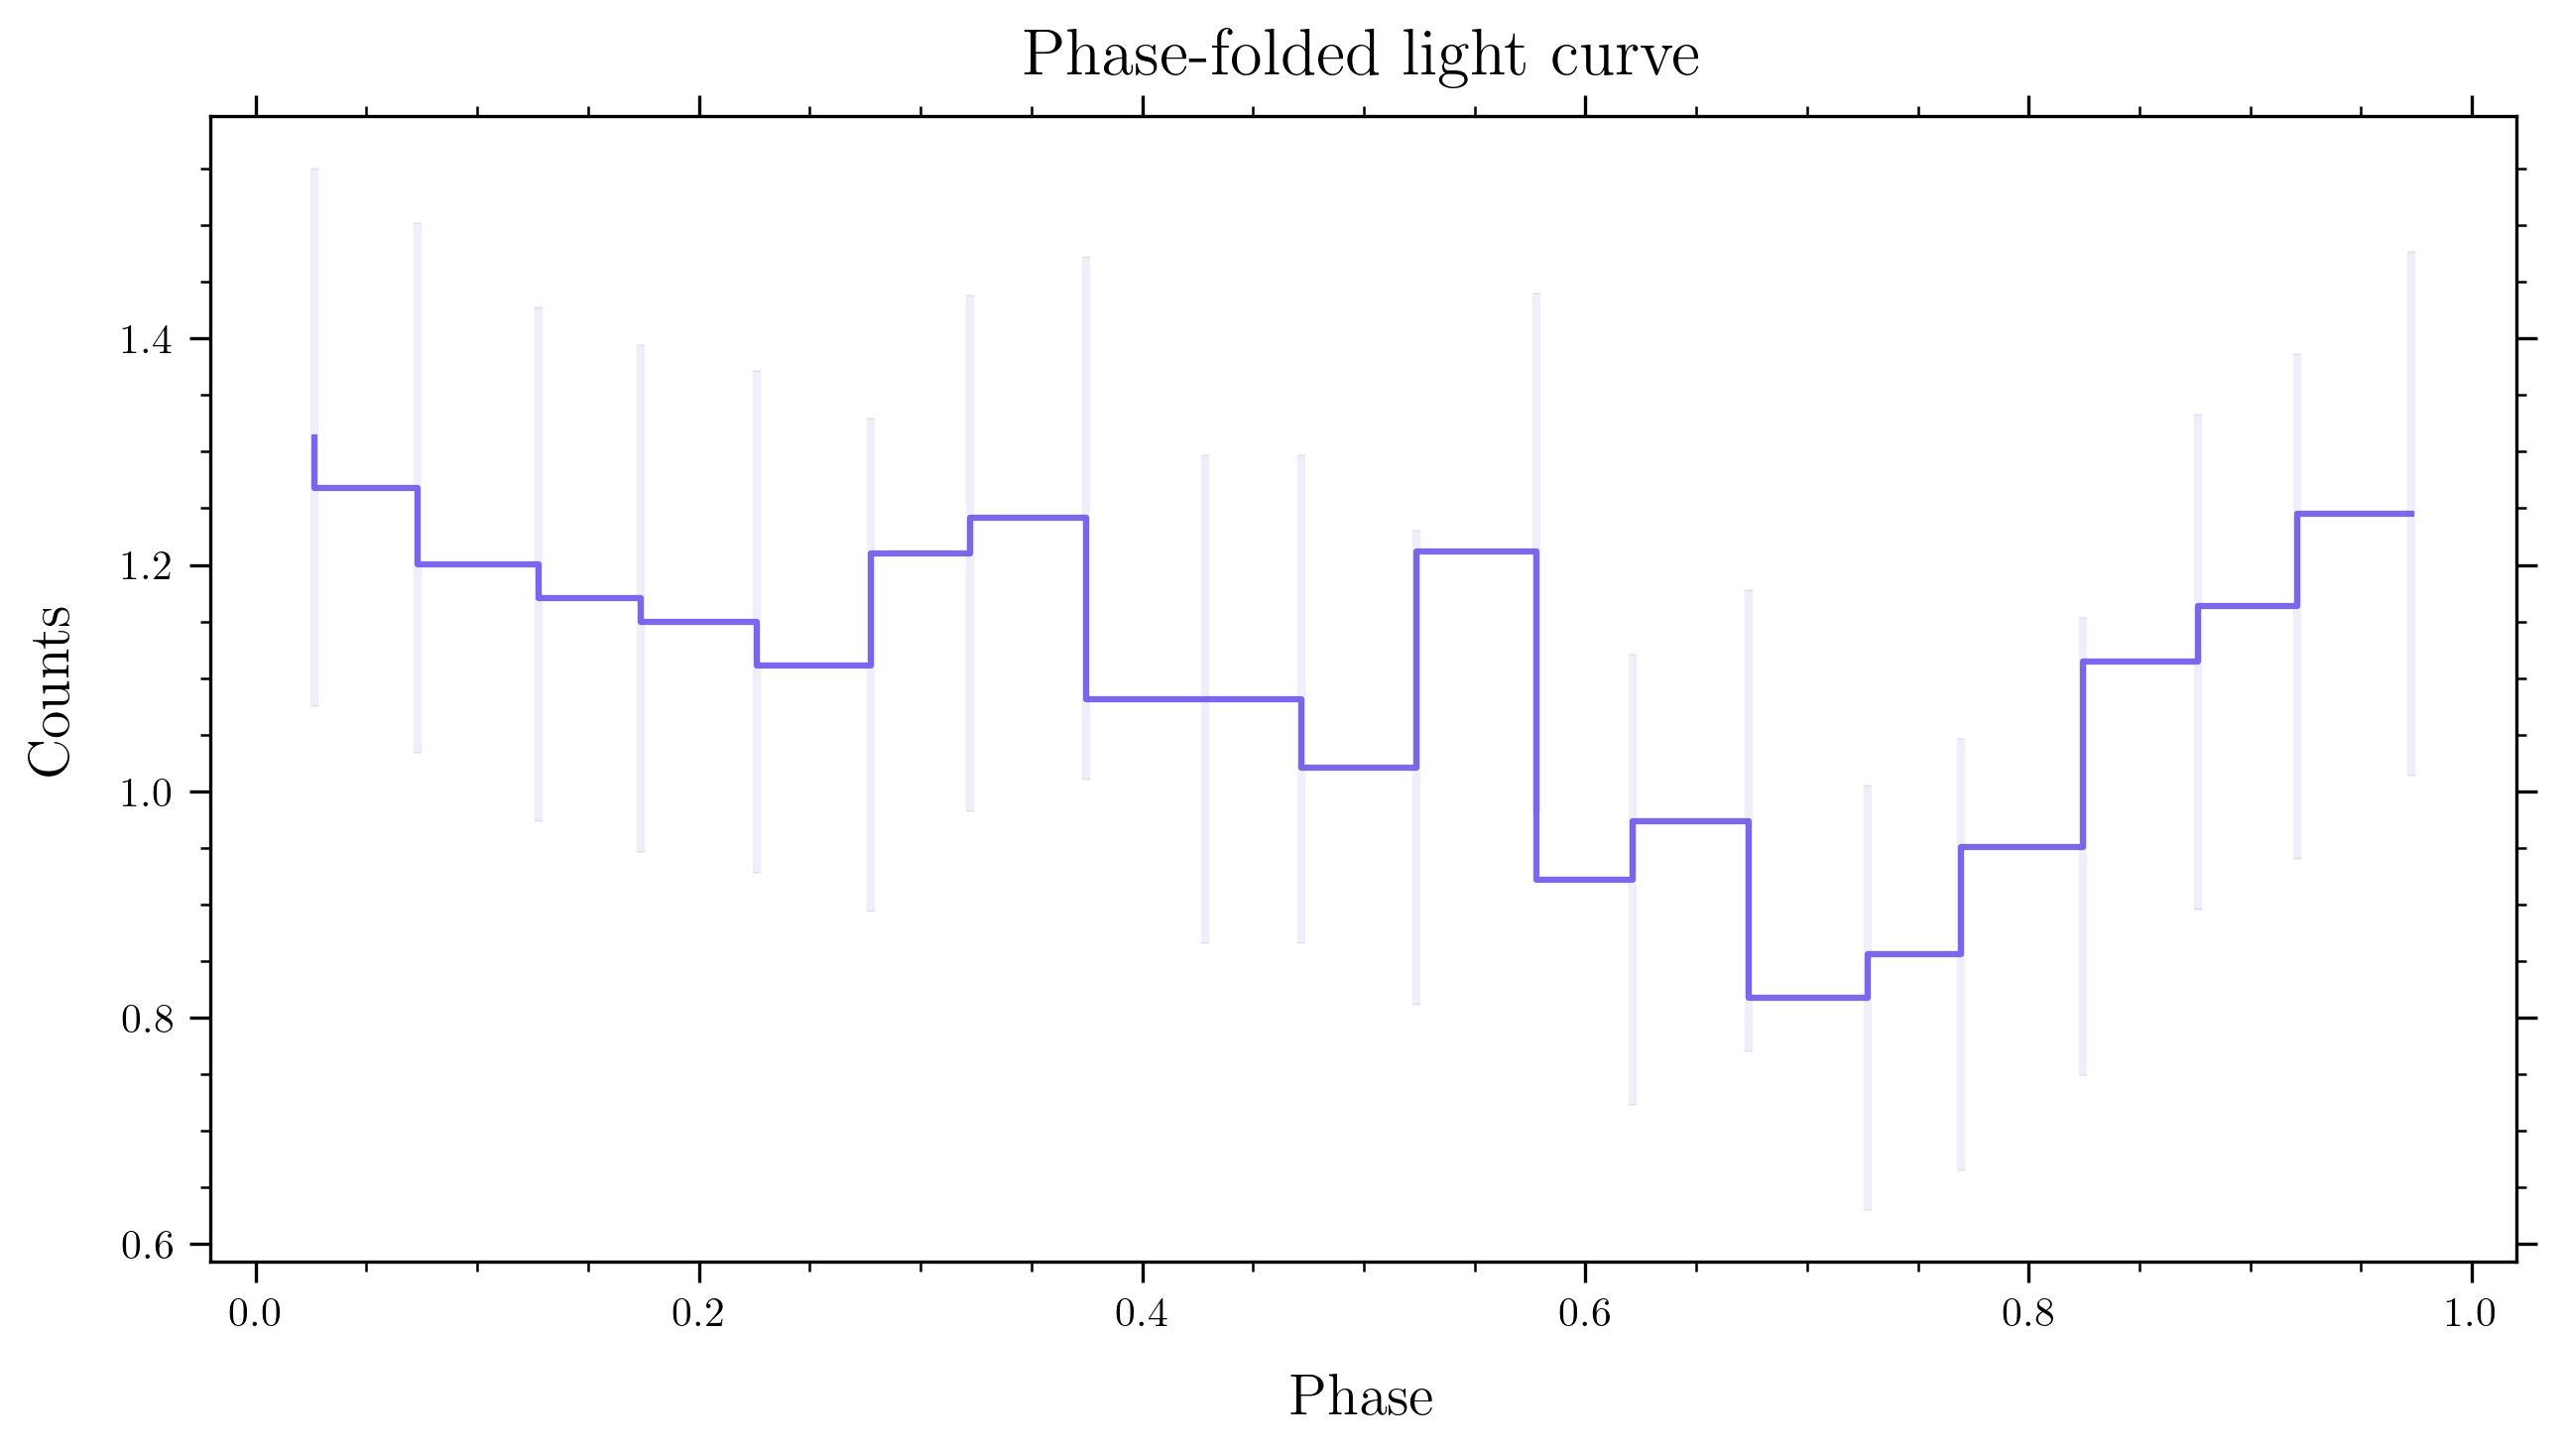

In [62]:
#downsample the data by averaging over 30 points
binned_phase = binned_statistic(sorted_phase, sorted_phase, bins=20, statistic='mean').statistic
binned_counts = binned_statistic(sorted_phase, sorted_counts, bins=20, statistic='mean').statistic
binned_error = binned_statistic(sorted_phase, sorted_counts_err, bins=20, statistic='mean').statistic
copy = binned_phase+1
zerototwo = np.concatenate((binned_phase, copy))
counts_zerototwo = np.concatenate((binned_counts, binned_counts))
plt.figure(figsize=(10, 5), dpi=300)
plt.step(binned_phase, binned_counts, color='mediumslateblue')
plt.errorbar(binned_phase+0.025, binned_counts, binned_error, fmt='o', color='slateblue', ms=0, elinewidth=2, alpha=0.1, capsize=1, capthick=0.5)
plt.xlabel('Phase', fontsize=14, labelpad=10)
plt.ylabel('Counts', fontsize=14, labelpad=10)
plt.title('Phase-folded light curve', fontsize=16, pad=10)
plt.show()

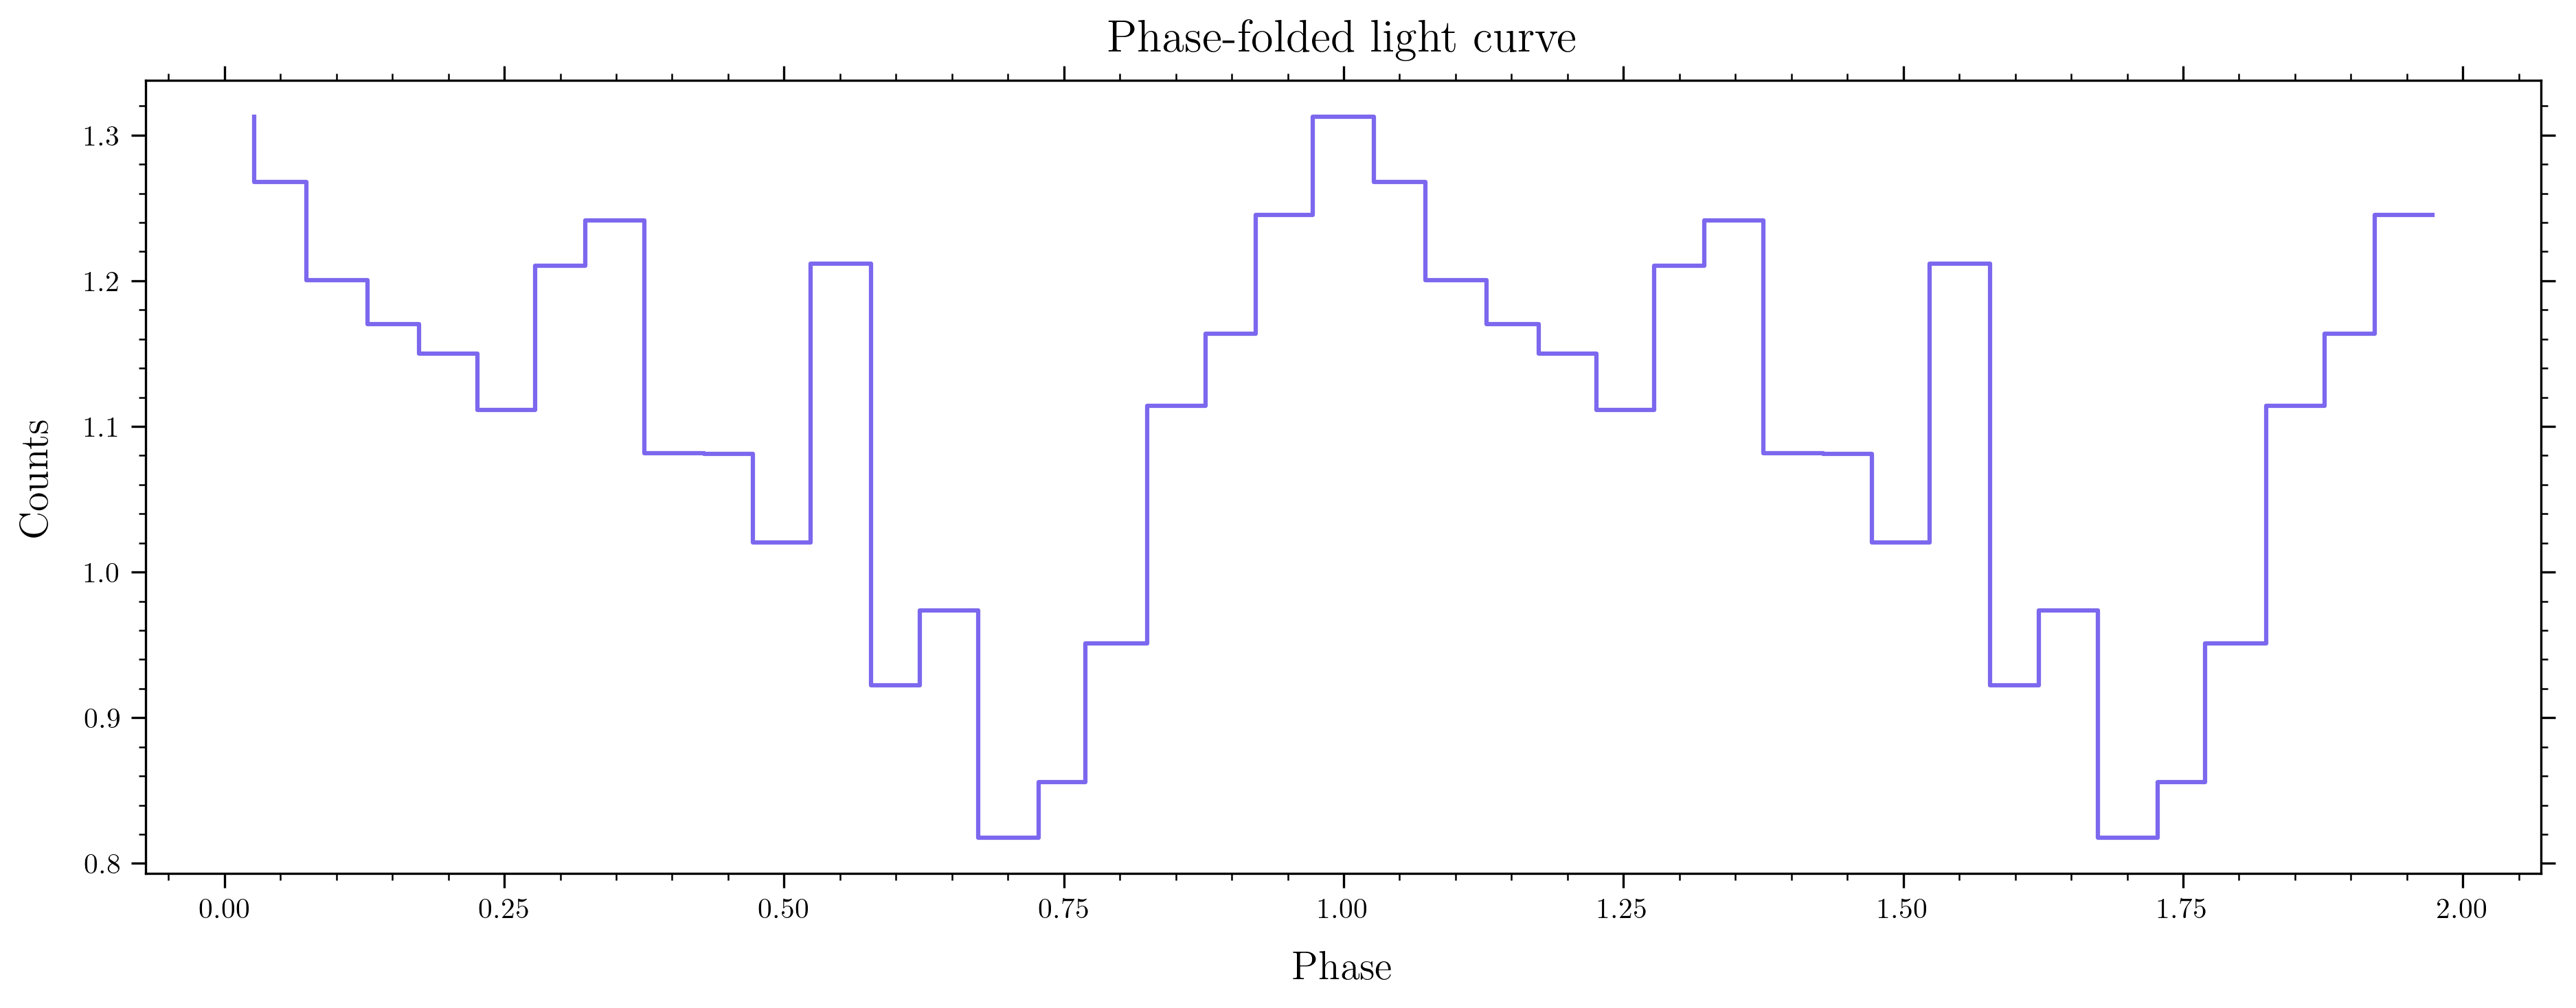

In [59]:
plt.figure(figsize=(15, 5), dpi=300)
plt.step(zerototwo, counts_zerototwo, color='mediumslateblue')
plt.xlabel('Phase', fontsize=14, labelpad=10)
plt.ylabel('Counts', fontsize=14, labelpad=10)
plt.title('Phase-folded light curve', fontsize=16, pad=10)
plt.show()

<ErrorbarContainer object of 3 artists>

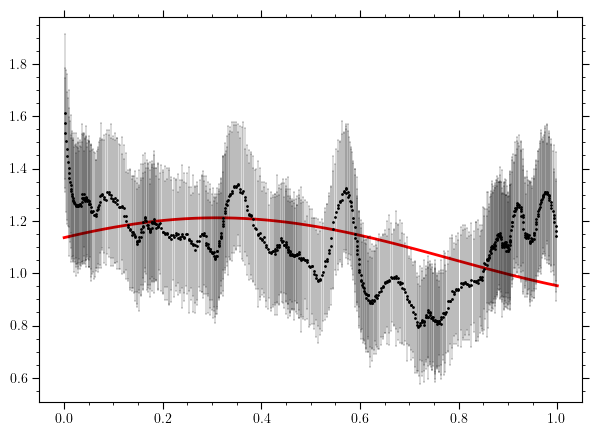

In [57]:
plt.figure(figsize=(7, 5), dpi=100)
plt.plot(t_fit, y_fit, color='r', lw=2)
plt.errorbar(phase[sort], filtered_counts, counts_err[sort],fmt='o', color='black', ms=1, elinewidth=0.2, capsize=1, capthick=0.2)

$\text{Flux } (\text{ergs } \text{cm}^{-2} \text{s}^{-1}$ $\AA^{-1}) =  \text{CPS} \times \text{Unit Conversion}$

$\text{m}_{\text{AB}} = -2.5\log{\text{CPS}}+\text{Zero Point}$

$\text{Unit Conversion for F148W} = 3.06\times 10^{-5}$

$\text{Zero Point for F148W} = 18.016$

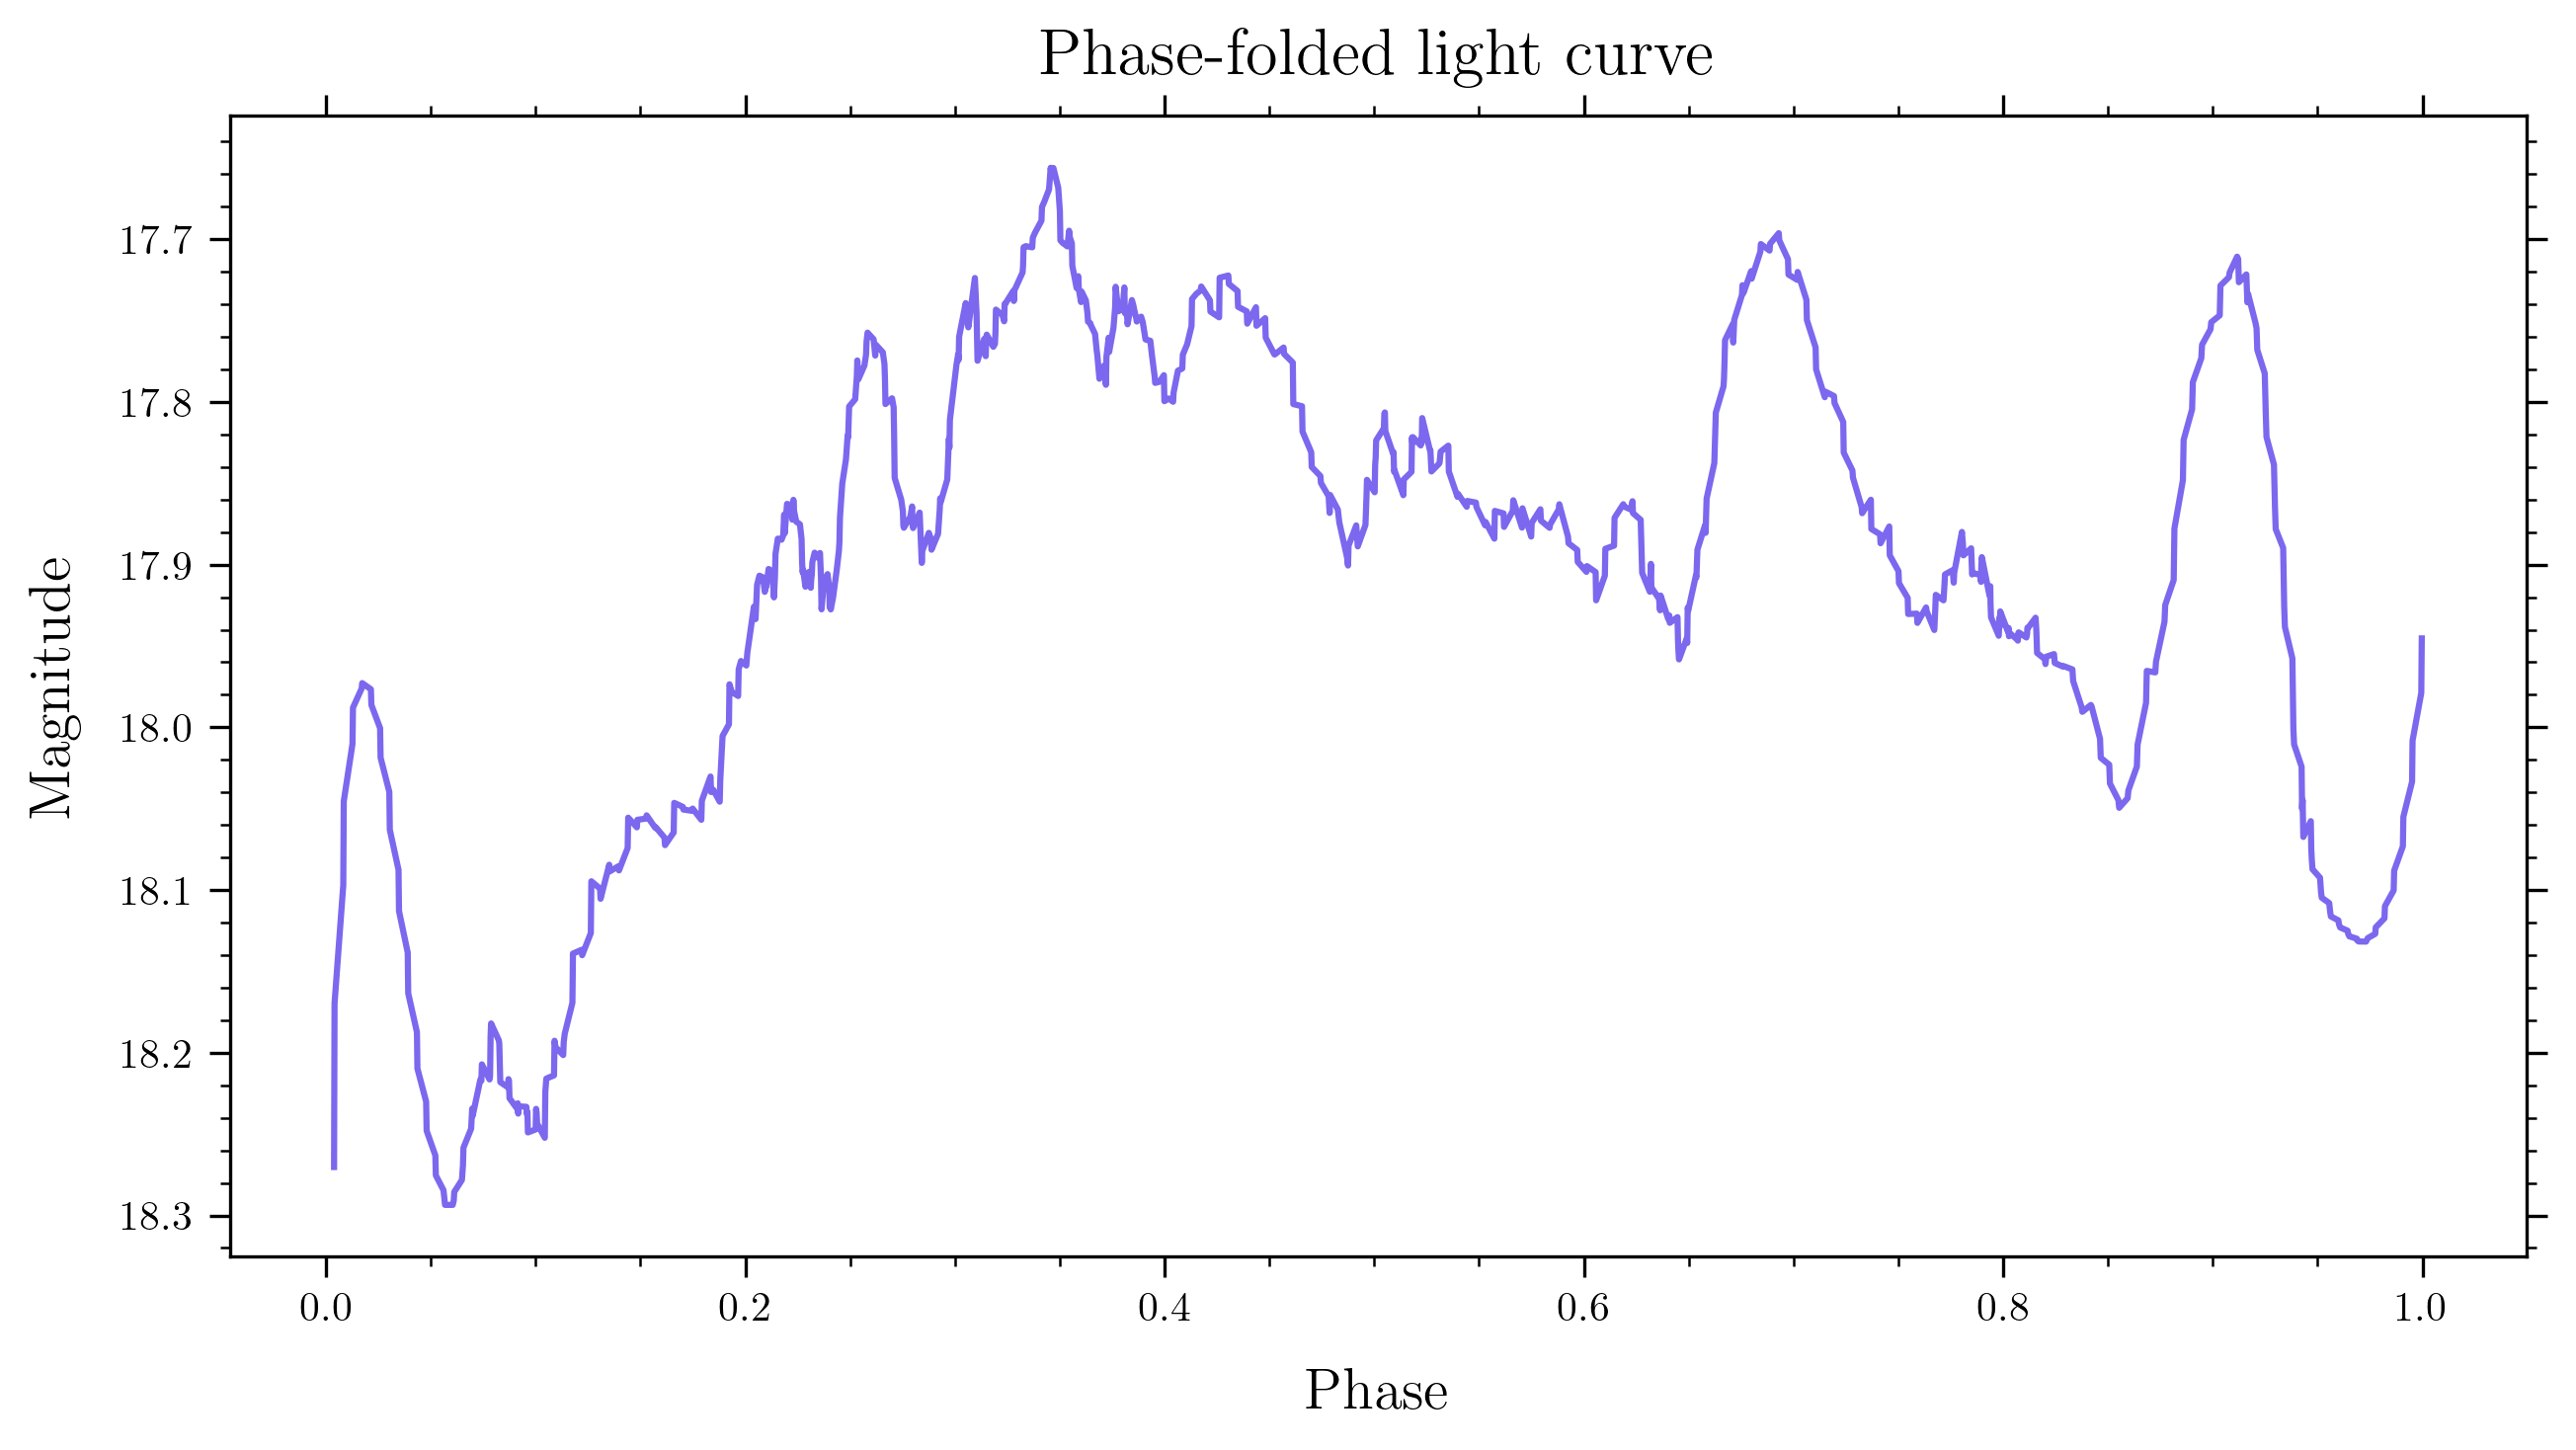

In [37]:
sorted_flux = filtered_counts*3.06e-5
sorted_flux_err = filtered_error*3.06e-5
sorted_m_ab = -2.5*np.log10(filtered_counts)+18.016
# sorted_m_ab_err = -2.5*np.log10(filtered_error)+18.016
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(sorted_phase, sorted_m_ab, color='mediumslateblue')
plt.xlabel('Phase', fontsize=14, labelpad=10)
plt.ylabel('Magnitude', fontsize=14, labelpad=10)
plt.title('Phase-folded light curve', fontsize=16, pad=10)
plt.gca().invert_yaxis()
plt.show()

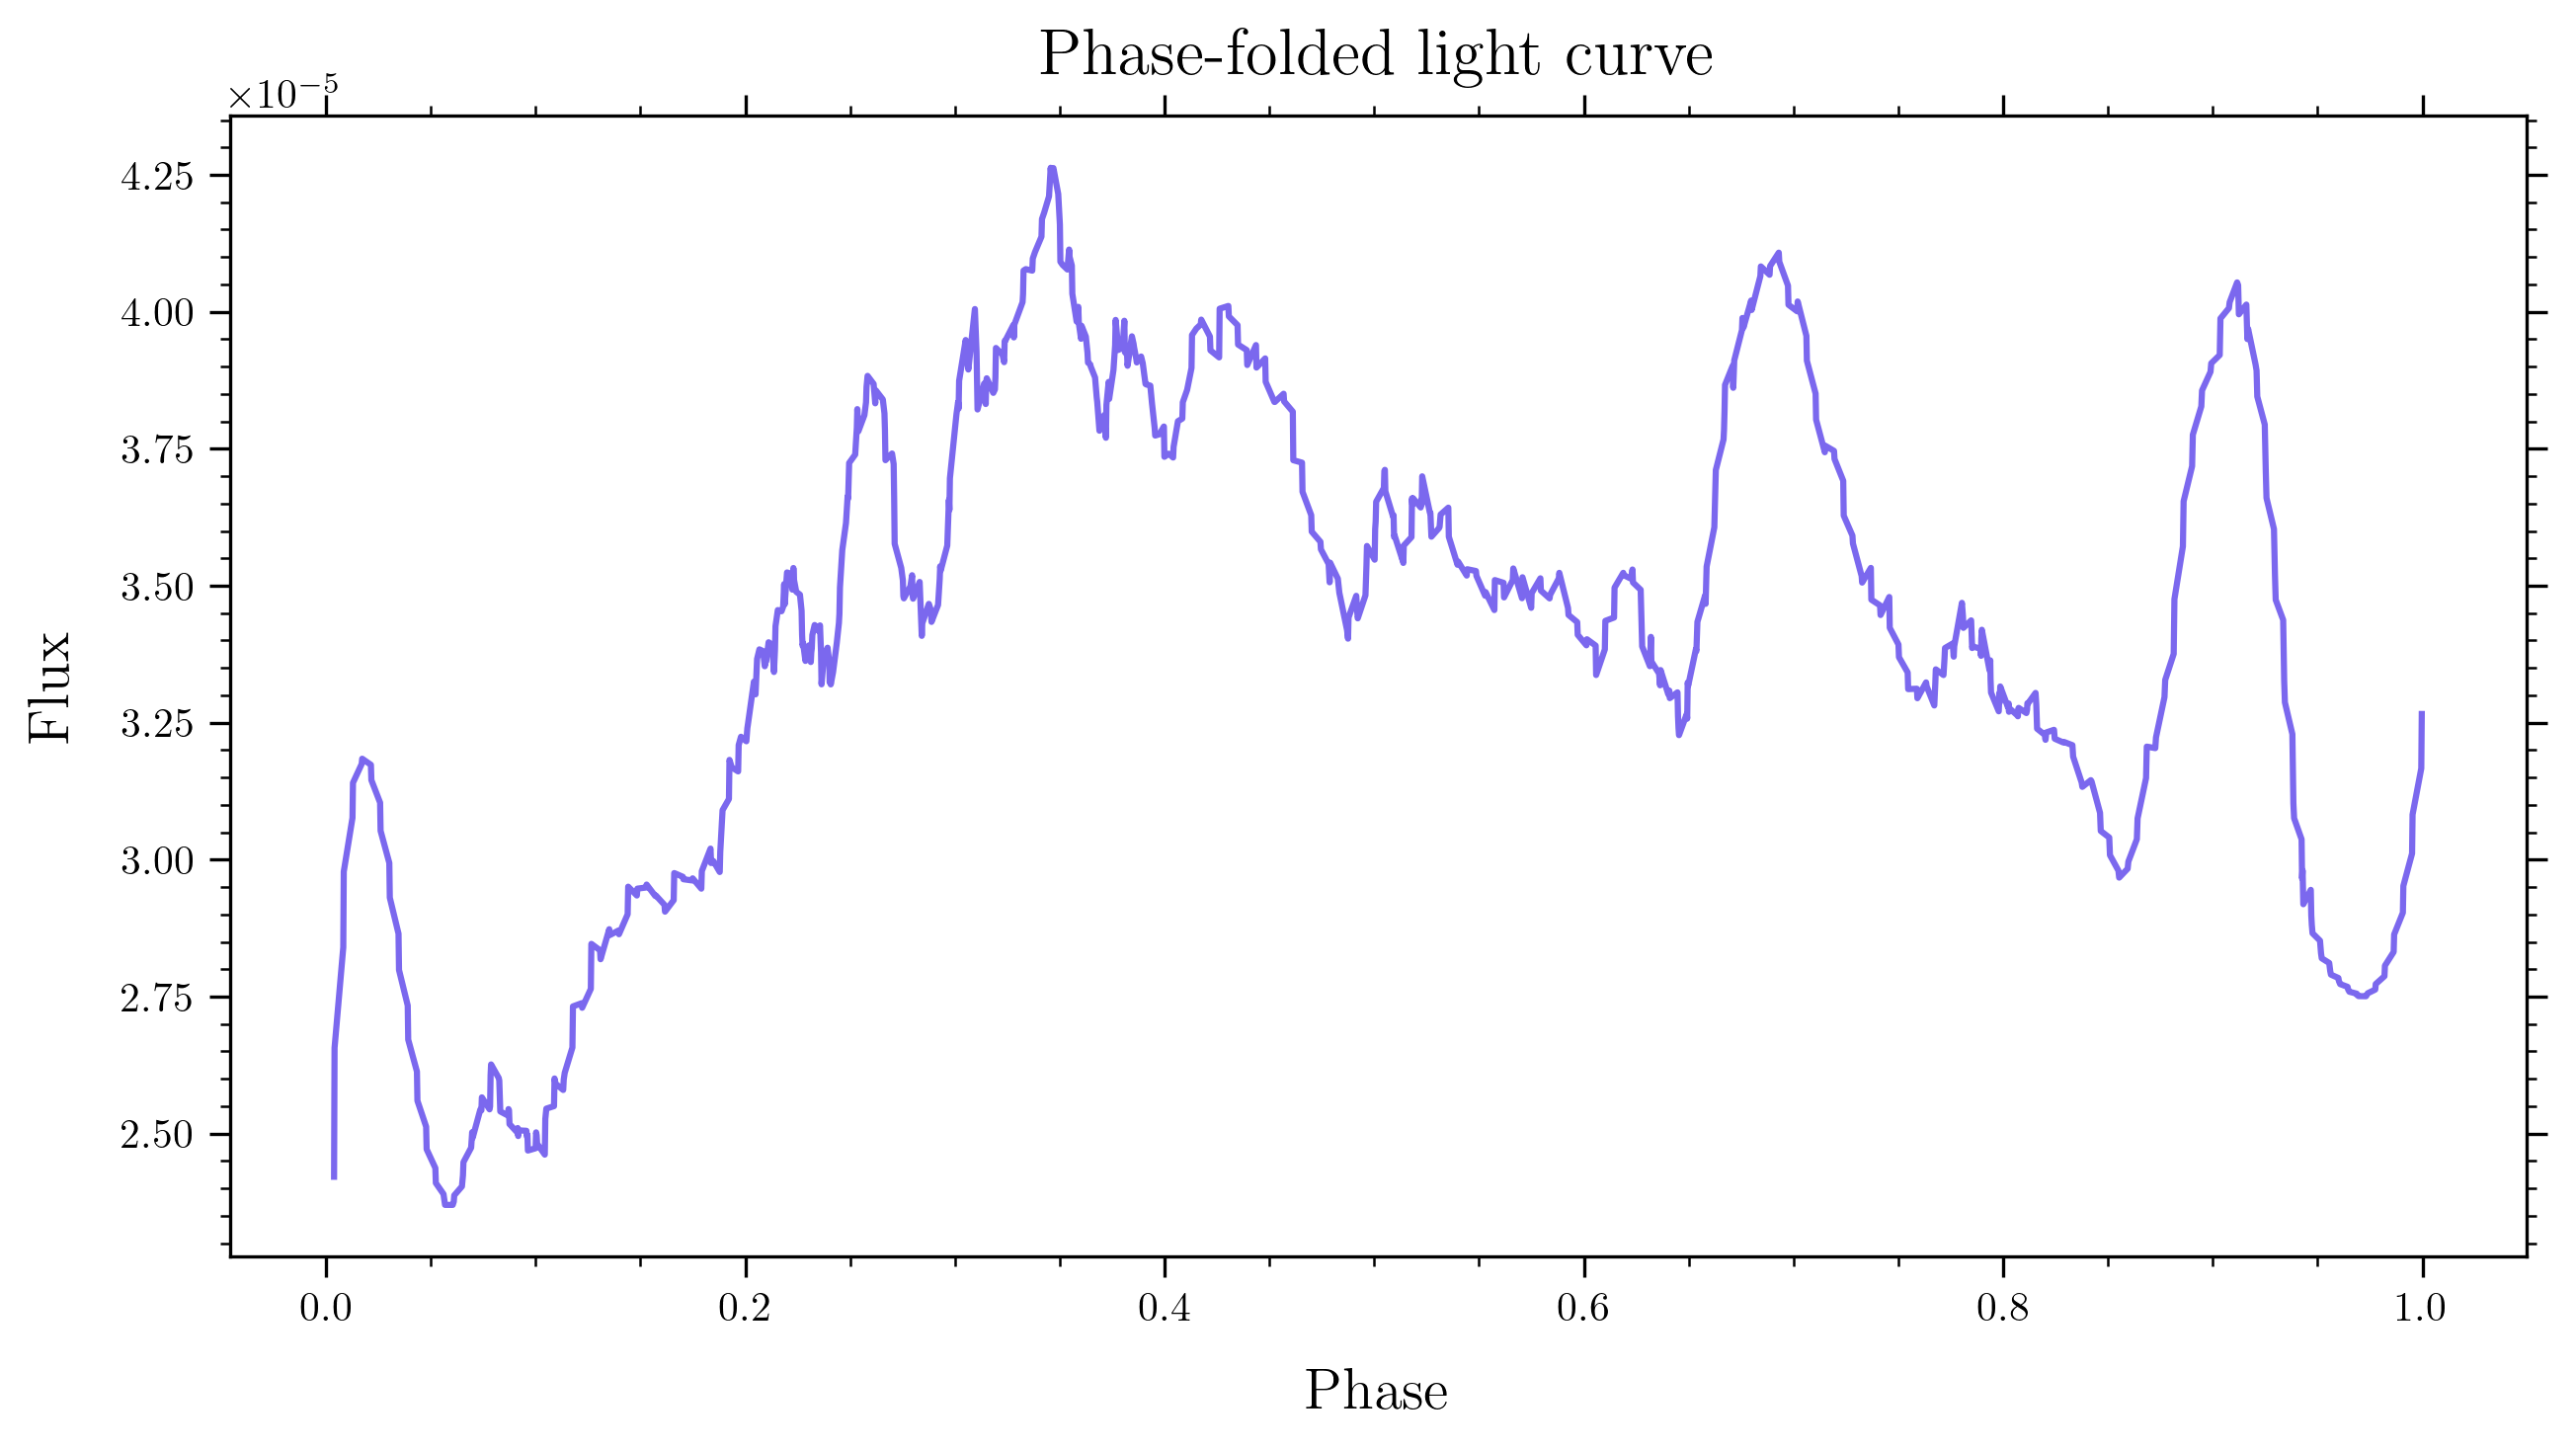

In [38]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(sorted_phase, sorted_flux, color='mediumslateblue')
plt.xlabel('Phase', fontsize=14, labelpad=10)
plt.ylabel('Flux', fontsize=14, labelpad=10)
plt.title('Phase-folded light curve', fontsize=16, pad=10)
plt.show()

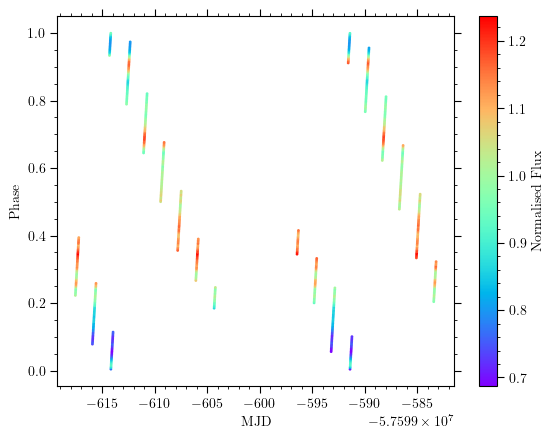

In [39]:
flux = counts*3.06e-5
normalised_flux = sorted_flux/np.sqrt(np.mean(sorted_flux**2))
plt.scatter(MJD_hour[sort], sorted_phase, c=normalised_flux, s=1, cmap='rainbow')
plt.colorbar(label='Normalised Flux')
plt.xlabel('MJD')
plt.ylabel('Phase')
plt.show()

-57599617.56096867 -57599583.21779138 0.0038284659385681152 0.999670222401619


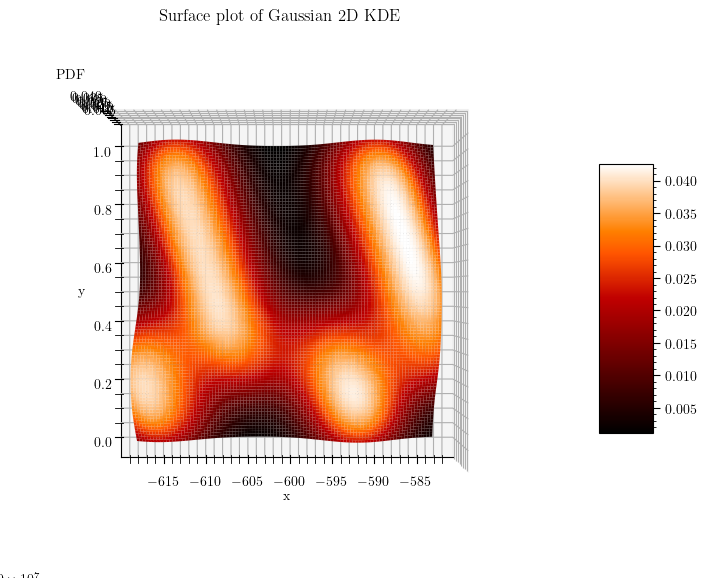

In [40]:
x = MJD_hour[sort]
y = sorted_phase
# Define the borders
xmin = min(x)
xmax = max(x)
ymin = min(y)
ymax = max(y)
print(xmin, xmax, ymin, ymax)
# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)(positions)
f = np.reshape(kernel.T, xx.shape)
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='gist_heat', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(90, -90)

Text(0.5, 1.0, '2D Gaussian Kernel density estimation')

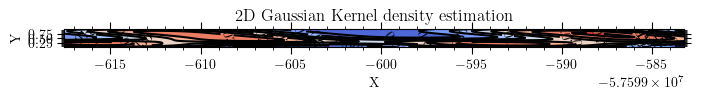

In [41]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(xx, yy, f, cmap='coolwarm')
ax.imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('2D Gaussian Kernel density estimation')